In [37]:
DATA_DIR = "./data/"
VALID_SIZE = .2
MODEL_PATH = "model.bin"

#file to download to run model:  
#1) https://howardhsu.github.io/dataset/ for domain embedding (need to download this!)

In [38]:
#!pip install fasttext
#!pip install transformers
#import nltk
#nltk.download('punkt')

In [39]:
from ast import FloorDiv
import pandas as pd
import numpy as np
import scipy
import nltk
import re
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from torch.optim import AdamW
from fasttext import load_model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, classification_report

In [40]:
df = pd.read_csv('../Dataset/data/restaurants_laptop_train_with_pos_cleaned.csv')

In [41]:
df.head()

,num,text,pos,aspect_tag,polarity
0,s_1,I,PRON,NAT,0
1,s_1,charge,VERB,NAT,0
2,s_1,it,PRON,NAT,0
3,s_1,at,ADP,NAT,0
4,s_1,night,NOUN,NAT,0


In [42]:
encoder = preprocessing.LabelEncoder()
df.loc[:, "aspect_tag"] = encoder.fit_transform(df["aspect_tag"])

sentences = df.groupby("num")["text"].apply(list).values
aspect_tags = df.groupby("num")["aspect_tag"].apply(list).values

print('num of aspect tags: {}'.format(len(encoder.classes_)))

np.where(encoder.classes_ == "AT")[0].item()

num of aspect tags: 2


0

In [43]:
print(len(sentences))
print(len(aspect_tags))

3432
3432


In [44]:
print(max(map(lambda x: len(x), sentences)))

80


In [45]:
# generate word_index list
def build_vocab(df):
    word_idx = {}
    for idx, word in enumerate(sorted(set(df.text.values))):
        word_idx[word] = idx + 1
    return word_idx

def gen_np_embedding(fn, word_idx, dim=100, emb=False):
    if emb:
        model = load_model(fn + ".bin")
    embedding = np.zeros((len(word_idx) + 2, dim))

    with open(fn, encoding="utf8") as f:
        for l in f:
            # for each line, get the word and its vector
            rec = l.rstrip().split(' ')
            if len(rec) == 2:  # skip the first line.
                continue
                # if the word in word_idx, fill the embedding
            if rec[0] in word_idx:
                embedding[word_idx[rec[0]]] = np.array([float(r) for r in rec[1:]])
    for w in word_idx:
        if embedding[word_idx[w]].sum() == 0.:
            if emb:
                embedding[word_idx[w]] = model.get_word_vector(w)
    return embedding

def create_train_data_restaurant(sentences, word_idx, aspect_tags, sent_len=83):
    train_X = np.zeros((len(sentences), sent_len), np.int16)
    mask = np.zeros_like(train_X)

    train_y = np.zeros((len(sentences), sent_len), np.int16)

    # iterate the sentence
    for sx, sent in enumerate(sentences):
        # write word index and tag in train_X
        try:
            for wx, word in enumerate(sent):
                train_X[sx, wx] = word_idx[word]
                mask[sx, wx] = 1
                train_y[sx, wx] = aspect_tags[sx][wx]
        except KeyError:
            continue

    return (train_X, mask), train_y



def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, dict):
        for k, v in data.items():
            data[k] = v.to(device)
        return data
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


def loss_fn(pred, mask, label):
    label.masked_fill_(~mask, -100)
    pred = pred.view(-1, 2)
    label = label.view(-1)
    loss = torch.nn.functional.cross_entropy(pred, label)
    return loss


def cal_acc(pred_tags, mask, true_tags):
    if isinstance(pred_tags, list):
        pred_tags = torch.cat(pred_tags, 0)
        mask = torch.cat(mask, 0)
        true_tags = torch.cat(true_tags, 0)
    pred_tags = pred_tags[mask]
    true_tags = true_tags[mask]
    acc = (pred_tags == true_tags).sum() / pred_tags.numel()
    f1 = f1_score(true_tags.cpu().numpy(), pred_tags.cpu().numpy(), labels=[0, 1], average='weighted')
    cm = confusion_matrix(true_tags.cpu().numpy(), pred_tags.cpu().numpy())

    return acc, f1, cm


In [46]:
class Model(torch.nn.Module):
    def __init__(self, gen_emb, domain_emb, num_classes=3, dropout=0.5):
        super(Model, self).__init__()
        self.gen_embedding = torch.nn.Embedding(gen_emb.shape[0], gen_emb.shape[1])
        self.gen_embedding.weight = torch.nn.Parameter(torch.from_numpy(gen_emb), requires_grad=False)
        self.domain_embedding = torch.nn.Embedding(domain_emb.shape[0], domain_emb.shape[1])
        self.domain_embedding.weight = torch.nn.Parameter(torch.from_numpy(domain_emb), requires_grad=False)
        self.conv1 = torch.nn.Conv1d(gen_emb.shape[1] + domain_emb.shape[1], 128, 5, padding=2)
        self.conv2 = torch.nn.Conv1d(gen_emb.shape[1] + domain_emb.shape[1], 128, 3, padding=1)

        self.dropout = torch.nn.Dropout(dropout)

        self.conv3 = torch.nn.Conv1d(256, 256, 5, padding=2)
        self.conv4 = torch.nn.Conv1d(256, 256, 5, padding=2)

        self.lstm = nn.LSTM(256, hidden_size=128, num_layers=1, bidirectional=True, batch_first=True)

        self.linear_ae = torch.nn.Linear(256, num_classes)

    def forward(self, x_train):
        x_emb = torch.cat((self.gen_embedding(x_train), self.domain_embedding(x_train)), dim=2)

        x_emb = self.dropout(x_emb).transpose(1, 2)

        x_conv = torch.nn.functional.relu(torch.cat((self.conv1(x_emb.float()), self.conv2(x_emb.float())), dim=1))
        x_conv = self.dropout(x_conv)

        x_conv = torch.nn.functional.relu(self.conv3(x_conv))
        x_conv = self.dropout(x_conv)

        x_conv = torch.nn.functional.relu(self.conv4(x_conv))
        x_conv = self.dropout(x_conv)

        x_conv = x_conv.transpose(1, 2)

        x_lstm, (hidden, cell) = self.lstm(x_conv)

        x_logit = self.linear_ae(x_lstm)

        return x_logit

In [47]:
word_indx = build_vocab(df)

fn = DATA_DIR + 'restaurant_emb.vec'
res_domain_embedding = gen_np_embedding(fn, word_indx, dim=100, emb=True)

fn = DATA_DIR + 'laptop_emb.vec'
lap_domain_embedding = gen_np_embedding(fn, word_indx, dim=100, emb=True)

res_domain_embedding = np.concatenate([res_domain_embedding, lap_domain_embedding], axis=0)

fn = DATA_DIR + 'glove.840B.300d.txt'
general_embedding = gen_np_embedding(fn, word_indx, dim=300, emb=False)


(X, mask), y = create_train_data_restaurant(sentences, word_indx, aspect_tags, sent_len=83)

X_train, X_valid, mask_train, mask_valid, y_train, y_valid = train_test_split(X, mask, y, test_size=VALID_SIZE)

In [48]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_ASPECT_TAGS = 2

dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(mask_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_valid), torch.Tensor(mask_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding, res_domain_embedding, num_classes=2), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


train samples:2745
valid samples:687


In [53]:
history = {
    "train_loss": list(),
    "aspact_train_acc": list(),
    "valid_loss": list(),
    "aspact_valid_acc": list(),
}

best_loss = np.inf

for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        feature, mask, label = data
        feature, mask, label = feature.long(), mask.bool(), label.long()
        optimizer.zero_grad()

        pred_logits = model(feature)
        loss = loss_fn(pred_logits, mask, label)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        masks.append(mask)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds, masks, labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)
            loss = loss_fn(pred_logits, mask, label)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            masks.append(mask)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds, masks, labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['aspact_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['aspact_valid_acc'].append(avg_test_acc.cpu().numpy())


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]



epoch 0
	train_loss:0.160 valid_loss:0.181
	train_acc:93.76% valid_acc:92.79%
	train_f1:0.937 valid_f1:0.928
	train_confusion_matrix:
[[ 5100  1512]
 [ 1187 35432]]
	valid_confusion_matrix:
[[1328  427]
 [ 386 9128]]


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]



epoch 1
	train_loss:0.158 valid_loss:0.182
	train_acc:93.82% valid_acc:92.83%
	train_f1:0.938 valid_f1:0.927
	train_confusion_matrix:
[[ 5134  1491]
 [ 1180 35430]]
	valid_confusion_matrix:
[[1301  454]
 [ 354 9160]]


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]



epoch 2
	train_loss:0.156 valid_loss:0.184
	train_acc:93.88% valid_acc:92.55%
	train_f1:0.938 valid_f1:0.924
	train_confusion_matrix:
[[ 5126  1505]
 [ 1136 35417]]
	valid_confusion_matrix:
[[1272  483]
 [ 357 9157]]


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]



epoch 3
	train_loss:0.151 valid_loss:0.183
	train_acc:94.06% valid_acc:92.80%
	train_f1:0.940 valid_f1:0.927
	train_confusion_matrix:
[[ 5204  1428]
 [ 1141 35473]]
	valid_confusion_matrix:
[[1295  460]
 [ 351 9163]]


100%|██████████| 1/1 [00:01<00:00,  1.21s/it]



epoch 4
	train_loss:0.147 valid_loss:0.183
	train_acc:94.10% valid_acc:92.93%
	train_f1:0.940 valid_f1:0.929
	train_confusion_matrix:
[[ 5164  1479]
 [ 1076 35593]]
	valid_confusion_matrix:
[[1311  444]
 [ 353 9161]]


100%|██████████| 1/1 [00:01<00:00,  1.26s/it]



epoch 5
	train_loss:0.147 valid_loss:0.177
	train_acc:94.30% valid_acc:93.23%
	train_f1:0.943 valid_f1:0.931
	train_confusion_matrix:
[[ 5276  1354]
 [ 1109 35469]]
	valid_confusion_matrix:
[[1303  452]
 [ 311 9203]]


100%|██████████| 1/1 [00:01<00:00,  1.25s/it]



epoch 6
	train_loss:0.145 valid_loss:0.173
	train_acc:94.30% valid_acc:93.40%
	train_f1:0.942 valid_f1:0.934
	train_confusion_matrix:
[[ 5241  1418]
 [ 1051 35619]]
	valid_confusion_matrix:
[[1358  397]
 [ 347 9167]]


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]



epoch 7
	train_loss:0.143 valid_loss:0.172
	train_acc:94.47% valid_acc:93.33%
	train_f1:0.944 valid_f1:0.933
	train_confusion_matrix:
[[ 5274  1358]
 [ 1036 35626]]
	valid_confusion_matrix:
[[1335  420]
 [ 332 9182]]


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]



epoch 8
	train_loss:0.140 valid_loss:0.181
	train_acc:94.65% valid_acc:92.95%
	train_f1:0.946 valid_f1:0.929
	train_confusion_matrix:
[[ 5325  1302]
 [ 1011 35629]]
	valid_confusion_matrix:
[[1345  410]
 [ 385 9129]]


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]



epoch 9
	train_loss:0.138 valid_loss:0.176
	train_acc:94.60% valid_acc:93.11%
	train_f1:0.945 valid_f1:0.930
	train_confusion_matrix:
[[ 5316  1328]
 [ 1010 35618]]
	valid_confusion_matrix:
[[1281  474]
 [ 302 9212]]


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]



epoch 10
	train_loss:0.139 valid_loss:0.167
	train_acc:94.63% valid_acc:93.39%
	train_f1:0.946 valid_f1:0.933
	train_confusion_matrix:
[[ 5347  1307]
 [ 1023 35693]]
	valid_confusion_matrix:
[[1323  432]
 [ 313 9201]]


100%|██████████| 1/1 [00:01<00:00,  1.22s/it]



epoch 11
	train_loss:0.133 valid_loss:0.174
	train_acc:94.88% valid_acc:93.17%
	train_f1:0.948 valid_f1:0.931
	train_confusion_matrix:
[[ 5362  1293]
 [  926 35744]]
	valid_confusion_matrix:
[[1314  441]
 [ 329 9185]]


100%|██████████| 1/1 [00:01<00:00,  1.19s/it]



epoch 12
	train_loss:0.129 valid_loss:0.166
	train_acc:95.07% valid_acc:93.20%
	train_f1:0.950 valid_f1:0.932
	train_confusion_matrix:
[[ 5422  1191]
 [  942 35705]]
	valid_confusion_matrix:
[[1364  391]
 [ 375 9139]]


100%|██████████| 1/1 [00:01<00:00,  1.28s/it]



epoch 13
	train_loss:0.129 valid_loss:0.172
	train_acc:94.97% valid_acc:93.30%
	train_f1:0.949 valid_f1:0.932
	train_confusion_matrix:
[[ 5434  1208]
 [  963 35596]]
	valid_confusion_matrix:
[[1318  437]
 [ 318 9196]]


100%|██████████| 1/1 [00:01<00:00,  1.32s/it]



epoch 14
	train_loss:0.127 valid_loss:0.168
	train_acc:95.04% valid_acc:93.50%
	train_f1:0.950 valid_f1:0.934
	train_confusion_matrix:
[[ 5450  1210]
 [  940 35771]]
	valid_confusion_matrix:
[[1311  444]
 [ 288 9226]]


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]



epoch 15
	train_loss:0.124 valid_loss:0.165
	train_acc:95.21% valid_acc:93.84%
	train_f1:0.952 valid_f1:0.938
	train_confusion_matrix:
[[ 5411  1225]
 [  849 35795]]
	valid_confusion_matrix:
[[1357  398]
 [ 296 9218]]


100%|██████████| 1/1 [00:01<00:00,  1.27s/it]



epoch 16
	train_loss:0.123 valid_loss:0.169
	train_acc:95.29% valid_acc:93.41%
	train_f1:0.953 valid_f1:0.933
	train_confusion_matrix:
[[ 5523  1128]
 [  907 35609]]
	valid_confusion_matrix:
[[1322  433]
 [ 310 9204]]


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]



epoch 17
	train_loss:0.122 valid_loss:0.158
	train_acc:95.29% valid_acc:93.85%
	train_f1:0.952 valid_f1:0.938
	train_confusion_matrix:
[[ 5482  1159]
 [  881 35778]]
	valid_confusion_matrix:
[[1386  369]
 [ 324 9190]]


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]



epoch 18
	train_loss:0.121 valid_loss:0.170
	train_acc:95.34% valid_acc:93.51%
	train_f1:0.953 valid_f1:0.935
	train_confusion_matrix:
[[ 5497  1148]
 [  868 35765]]
	valid_confusion_matrix:
[[1361  394]
 [ 337 9177]]


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


epoch 19
	train_loss:0.121 valid_loss:0.167
	train_acc:95.43% valid_acc:93.69%
	train_f1:0.954 valid_f1:0.936
	train_confusion_matrix:
[[ 5526  1118]
 [  862 35799]]
	valid_confusion_matrix:
[[1326  429]
 [ 282 9232]]


(0.85, 1.0)

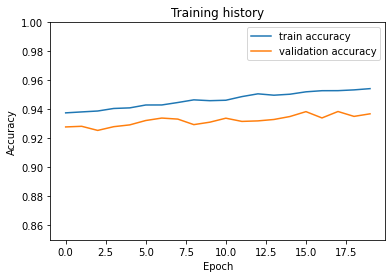

In [54]:
plt.plot(history['aspact_train_acc'], label='train accuracy')
plt.plot(history['aspact_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.85, 1])

In [55]:
def get_classification_report(test_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_aspect_tags = []
    final_true_aspect_tags = []


    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)

            pred_tags = pred_logits.max(-1)[1]

            pred_tags = pred_tags[mask]
            label = label[mask]

            final_pred_aspect_tags.extend(pred_tags)
            final_true_aspect_tags.extend(label)

    final_pred_aspect_tags = torch.stack(final_pred_aspect_tags).cpu()
    final_true_aspect_tags = torch.stack(final_true_aspect_tags).cpu()
        
    print(classification_report(final_true_aspect_tags, final_pred_aspect_tags, 
                                target_names=encoder.classes_))
    
get_classification_report(test_loader, model, model_path=MODEL_PATH)

Loading saved model from: model.bin


100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

              precision    recall  f1-score   support

          AT       0.79      0.90      0.84      1755
         NAT       0.98      0.96      0.97      9514

    accuracy                           0.95     11269
   macro avg       0.89      0.93      0.90     11269
weighted avg       0.95      0.95      0.95     11269

